In [1]:
import networkx as nx
import json
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.image import imread
import matplotlib
# 设置全局字体为'Times New Roman'
matplotlib.rcParams['font.family'] = 'Times New Roman'

In [2]:
#定义作战环作战效能
def S_G(G):
    total_gamma = 0
    # 获取图中所有节点类型为 'S' 的节点
    s_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == "S"]
    # 遍历图中的每一个 'S' 节点
    for s_node in s_nodes:
        # 获取 'S' 节点的邻居节点
        s_neighbors = list(G.neighbors(s_node))
        # 遍历 'S' 节点的每一个邻居节点，假设为决策节点 'D'
        for d_node in s_neighbors:
            if G.nodes[d_node]['type'] == 'D':
                # 获取决策节点 'D' 的邻居节点，假设为影响节点 'I'
                d_neighbors = list(G.neighbors(d_node))
                for i_node in d_neighbors:
                    if G.nodes[i_node]['type'] == 'I':
                        # 计算作战环的长度 |l_j|，即包含节点数
                        length_lj = 3  # 因为是固定的 S->D->I 结构，长度为 3
                        # 计算作战环的作战能力 U(l_j)
                        # print('s_node',s_node, 'd_node',d_node, 'i_node',i_node)
                        U_lj = (G.nodes[s_node]['CAs'] * G.nodes[d_node]['CAd'] * G.nodes[i_node]['CAi']) / length_lj
                        # 累加到总的网络作战能力
                        total_gamma += U_lj
        #遍历S节点的每一个邻居节点，假设为侦察节点S
        for s2_node in s_neighbors:
            if G.nodes[s2_node]['type']=='S':
                #获取侦察节点S的邻居节点，假设为决策节点D
                s2_neighbors =list(G.neighbors(s2_node))
                for d_node in s2_neighbors:
                    if G.nodes[d_node]['type'] =='D':
                        #获取决策节点S的邻居节点，假设为影响节点I
                        d_neighbors = list(G.neighbors(d_node))
                        for i_node in d_neighbors:
                            if G.nodes[i_node]['type'] =='I':
                                length_lj =4
                                # print('s_node',s_node,'s2_node',s2_node,'d_node',d_node,'i_node',i_node)
                                U_lj=((G.nodes[s_node]['CAs']+G.nodes[s2_node]['CAs']) * G.nodes[d_node]['CAd'] * G.nodes[i_node]['CAi']) / length_lj
                                total_gamma += U_lj

        #遍历S节点的每一个邻居节点，假设为决策节点D
        for d_node in s_neighbors:
            if G.nodes[d_node]['type'] == 'D':
                d_neighbors = list(G.neighbors(d_node))
                for d2_node in d_neighbors:
                    if G.nodes[d2_node]['type'] =='D':
                        d2_neighbors =list(G.neighbors(d2_node))
                        for i_node in d2_neighbors:
                            if G.nodes[i_node]['type'] =='I':
                                length_lj = 4
                                # print('s_node', s_node,'d_node',d_node, 'd2_node',d2_node,'i_node',i_node)
                                U_lj = (G.nodes[s_node]['CAs'] *(G.nodes[d_node]['CAd']+G.nodes[d2_node]['CAd']) * G.nodes[i_node]['CAi']) / length_lj
                                total_gamma += U_lj
        for s2_node in s_neighbors:
            if G.nodes[s2_node]['type']=='S':
                s2_neighbors= list(G.neighbors(s2_node))
                for d_node in s2_neighbors:
                    if G.nodes[d_node]['type']=='D':
                        d_neighbors = list(G.neighbors(d_node))
                        for d2_node in d_neighbors:
                            if G.nodes[d2_node]['type']=='D':
                                d2_neighbors =list(G.neighbors(d2_node))
                                for i_node in d2_neighbors:
                                    if G.nodes[i_node]['type']=='I':
                                        length_lj = 5
                                        # print('s_node',s_node, 's2_node',s2_node,'d_node',d_node, 'd2_node',d2_node, 'i_node',i_node)
                                        U_lj = ((G.nodes[s_node]['CAs']+G.nodes[s2_node]['CAs']) * (G.nodes[d_node]['CAd'] + G.nodes[d2_node]['CAd']) * G.nodes[i_node]['CAi']) / length_lj
                                        total_gamma += U_lj
    return total_gamma

#计算重新标度作战能力指数
def Q(A, G):
    if(S_G(A)>0):
        q = float(S_G(A))/float(S_G(G))
    else:
        q = 0
    return q

#求取最大连通片大小
def get_num_large(G):
    if len(G) == 0:
        return 0  # 如果图为空，则相对规模为0
    else:
        largest_cc = max(nx.weakly_connected_components(G), key=len)  # 取顶点数最多连通子图来分析
        return len(largest_cc)
    #计算重新标度作战能力指数

#定义相对连通片规模
def relative_get_num_large(G):
    if(get_num_large(A)>0):
        q = get_num_large(A)/get_num_large(G)
    else:
        q = 0
    return q

#=====================以ANC为评价指标==========================
#-----------不考虑重构-------------------
# 不考虑重构-最大度攻击
def PMA_withoutrecon_ANC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             node = random.choice(list(G.nodes()))
            max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 不考虑重构-随机攻击
def RA_withoutrecon_ANC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            node = random.choice(list(H.nodes()))
            #             max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            #             node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 不考虑重构-优先侦察节点攻击
def PSA_withoutrecon_ANC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            #             node = random.choice(list(H.nodes()))
            S_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'S']
            # 如果没有类型为 "S" 的节点，直接返回
            if not S_nodes:
                remaining_nodes = list(set(H.nodes()) - set(S_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "S" 的节点中最大度的节点
                max_degree_node = max(S_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 不考虑重构-优先决策节点攻击
def PDA_withoutrecon_ANC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            #             node = random.choice(list(H.nodes()))
            D_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'D']
            # 如果没有类型为 "D" 的节点，直接返回
            if not D_nodes:
                remaining_nodes = list(set(H.nodes()) - set(D_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "D" 的节点中最大度的节点
                max_degree_node = max(D_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 不考虑重构-优先影响节点攻击
def PIA_withoutrecon_ANC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            #             node = random.choice(list(H.nodes()))
            I_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'I']
            # 如果没有类型为 "I" 的节点，直接返回
            if not I_nodes:
                remaining_nodes = list(set(H.nodes()) - set(I_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "I" 的节点中最大度的节点
                max_degree_node = max(I_nodes, key=lambda node: H.degree(node))
                node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C


#-----------随机重构-------------------
# 随机重构-最大度攻击
def PMA_random_ANC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            #             node = random.choice(list(G.nodes()))
            max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 随机重构-随机攻击
def RA_random_ANC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            node = random.choice(list(H.nodes()))
            #             max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            #             node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 随机重构-优先侦察节点攻击
def PSA_random_ANC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            S_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'S']
            # 如果没有类型为 "S" 的节点，直接返回
            if not S_nodes:
                remaining_nodes = list(set(H.nodes()) - set(S_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "S" 的节点中最大度的节点
                max_degree_node = max(S_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 随机重构-优先决策节点攻击
def PDA_random_ANC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            D_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'D']
            # 如果没有类型为 "D" 的节点，直接返回
            if not D_nodes:
                remaining_nodes = list(set(H.nodes()) - set(D_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "D" 的节点中最大度的节点
                max_degree_node = max(D_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 随机重构-优先影响节点攻击
def PIA_random_ANC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            I_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'I']
            # 如果没有类型为 "I" 的节点，直接返回
            if not I_nodes:
                remaining_nodes = list(set(H.nodes()) - set(I_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "I" 的节点中最大度的节点
                max_degree_node = max(I_nodes, key=lambda node: H.degree(node))
                node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C


#-----------结构相似性重构-------------------
#定义相似度
def salton_similarity(G, node1, node2):
    neighbors_node1 = set(G.neighbors(node1))
    neighbors_node2 = set(G.neighbors(node2))
    intersection_size = len(neighbors_node1.intersection(neighbors_node2))
    if intersection_size == 0:
        return 0
    degree_node1 = G.degree(node1)
    degree_node2 = G.degree(node2)
    salton_similarity = intersection_size / ((degree_node1 * degree_node2) ** 0.5)
    return salton_similarity

#相似性重构-最大度攻击
def PMA_MaxSalton_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#相似性重构-随机攻击
def RA_MaxSalton_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            node = random.choice(list(H.nodes()))
            #             max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            #             node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#相似性重构-优先侦察节点攻击
def PSA_MaxSalton_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            S_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'S']
            # 如果没有类型为 "S" 的节点，直接返回
            if not S_nodes:
                remaining_nodes = list(set(H.nodes()) - set(S_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "S" 的节点中最大度的节点
                max_degree_node = max(S_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#相似性重构-优先决策节点攻击
def PDA_MaxSalton_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            D_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'D']
            # 如果没有类型为 "D" 的节点，直接返回
            if not D_nodes:
                remaining_nodes = list(set(H.nodes()) - set(D_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "D" 的节点中最大度的节点
                max_degree_node = max(D_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#相似性重构-优先影响节点攻击
def PIA_MaxSalton_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            I_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'I']
            # 如果没有类型为 "I" 的节点，直接返回
            if not I_nodes:
                remaining_nodes = list(set(H.nodes()) - set(I_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "I" 的节点中最大度的节点
                max_degree_node = max(I_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#-----------功能相似性重构-------------------
#功能相似性重构-最大度攻击
def fun_similarity(G, node1, node2):
    # Assuming G is a graph object where nodes have attributes CAs, CAi, CAd

    S_CAs = 0
    S_CAi = 0
    S_CAd = 0

    if 'CAs' in G.nodes[node1] and 'CAs' in G.nodes[node2]:
        CAs_node1 = G.nodes[node1]['CAs']
        CAs_node2 = G.nodes[node2]['CAs']
        if CAs_node1 != 0 and CAs_node2 != 0:
            S_CAs = math.exp(-(abs(CAs_node1 - CAs_node2) / CAs_node1 + abs(CAs_node1 - CAs_node2) / CAs_node2))
        else:
            S_CAs = 0

    if 'CAi' in G.nodes[node1] and 'CAi' in G.nodes[node2]:
        CAi_node1 = G.nodes[node1]['CAi']
        CAi_node2 = G.nodes[node2]['CAi']
        if CAi_node1 != 0 and CAi_node2 != 0:
            S_CAi = math.exp(-(abs(CAi_node1 - CAi_node2) / CAi_node1 + abs(CAi_node1 - CAi_node2) / CAi_node2))
        else:
            S_CAi = 0

    if 'CAd' in G.nodes[node1] and 'CAd' in G.nodes[node2]:
        CAd_node1 = G.nodes[node1]['CAd']
        CAd_node2 = G.nodes[node2]['CAd']
        if CAd_node1 != 0 and CAd_node2 != 0:
            S_CAd = math.exp(-(abs(CAd_node1 - CAd_node2) / CAd_node1 + abs(CAd_node1 - CAd_node2) / CAd_node2))
        else:
            S_CAd = 0

    # Return the maximum of the three similarities
    return max(S_CAs, S_CAi, S_CAd)

#功能相似性重构-随机攻击
def PMA_MaxFun_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            node = max_degree_node

            # 创建字典来存储节点与其 Fun 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 fun 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 fun 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#功能相似性重构-随机攻击
def RA_MaxFun_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            node = random.choice(list(H.nodes()))
            #             max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            #             node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 Salton 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#功能相似性重构-优先侦察节点攻击
def PSA_MaxFun_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            S_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'S']
            # 如果没有类型为 "S" 的节点，直接返回
            if not S_nodes:
                remaining_nodes = list(set(H.nodes()) - set(S_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "S" 的节点中最大度的节点
                max_degree_node = max(S_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 Salton 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#功能相似性重构-优先决策节点攻击
def PDA_MaxFun_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            D_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'D']
            # 如果没有类型为 "D" 的节点，直接返回
            if not D_nodes:
                remaining_nodes = list(set(H.nodes()) - set(D_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "D" 的节点中最大度的节点
                max_degree_node = max(D_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 Salton 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#功能相似性重构-优先影响节点攻击
def PIA_MaxFun_ANC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(get_num_large(H) / x)
            #             C.append(Q(H, G, CAi, CAd, CAs))
            I_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'I']
            # 如果没有类型为 "I" 的节点，直接返回
            if not I_nodes:
                remaining_nodes = list(set(H.nodes()) - set(I_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "I" 的节点中最大度的节点
                max_degree_node = max(I_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 Salton 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#=====================以ANOC为评价指标==========================
#-----------不考虑重构-------------------
#混合优先攻击-不考虑重构
def PMA_withoutrecon_ANOC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            #             C.append(get_num_large(H) / x)
            C.append(Q(H, G))
            #             node = random.choice(list(G.nodes()))
            max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            #             if len(G.nodes()) > 0 and node_type is not None:
            #                 same_type_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == node_type]
            #                 if same_type_nodes:
            #                     min_degree_node = min(G.degree(same_type_nodes), key=lambda x: x[1])[0]
            #                     replacement_node = min_degree_node
            # #                     replacement_node = random.choice(same_type_nodes)
            #                     if node != replacement_node:
            #                         for neighbor in NN:
            #                             if neighbor != replacement_node:  # 确保不形成自环
            #                                 G.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#随机攻击-不考虑重构
def RA_withoutrecon_ANOC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            #             C.append(get_num_large(H) / x)
            C.append(Q(H, G))
            node = random.choice(list(H.nodes()))
            #             max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            #             node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)了      
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#优先侦察节点攻击-不考虑重构
def PSA_withoutrecon_ANOC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            #             C.append(get_num_large(H) / x)
            C.append(Q(H, G))
            #             node = random.choice(list(H.nodes()))
            S_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'S']
            # 如果没有类型为 "S" 的节点，直接返回
            if not S_nodes:
                remaining_nodes = list(set(H.nodes()) - set(S_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "S" 的节点中最大度的节点
                max_degree_node = max(S_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#优先决策节点攻击-不考虑重构
def PDA_withoutrecon_ANOC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            #             C.append(get_num_large(H) / x)
            C.append(Q(H, G))
            #             node = random.choice(list(H.nodes()))
            D_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'D']
            # 如果没有类型为 "D" 的节点，直接返回
            if not D_nodes:
                remaining_nodes = list(set(H.nodes()) - set(D_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "D" 的节点中最大度的节点
                max_degree_node = max(D_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#优先影响节点攻击-不考虑重构
def PIA_withoutrecon_ANOC(G):
    H = G.copy()
    x = len(H.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            #             C.append(get_num_large(H) / x)
            C.append(Q(H, G))
            #             node = random.choice(list(H.nodes()))
            I_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'I']
            # 如果没有类型为 "I" 的节点，直接返回
            if not I_nodes:
                remaining_nodes = list(set(H.nodes()) - set(I_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "I" 的节点中最大度的节点
                max_degree_node = max(I_nodes, key=lambda node: H.degree(node))
                node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)

    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#-----------随机重构-------------------
# 随机重构-最大度攻击
def PMA_random_ANOC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            #             node = random.choice(list(G.nodes()))
            max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         #                     min_degree_node = min(H.degree(same_type_nodes), key=lambda x: x[1])[0]
            #         #                     replacement_node = min_degree_node
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
# 随机重构-随机攻击
def RA_random_ANOC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            node = random.choice(list(H.nodes()))
            #             max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            #             node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         #                     min_degree_node = min(H.degree(same_type_nodes), key=lambda x: x[1])[0]
            #         #                     replacement_node = min_degree_node
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
# 随机重构-优先侦察节点攻击
def PSA_random_ANOC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            S_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'S']
            # 如果没有类型为 "S" 的节点，直接返回
            if not S_nodes:
                remaining_nodes = list(set(H.nodes()) - set(S_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "S" 的节点中最大度的节点
                max_degree_node = max(S_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         #                     min_degree_node = min(H.degree(same_type_nodes), key=lambda x: x[1])[0]
            #         #                     replacement_node = min_degree_node
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
# 随机重构-优先决策节点攻击
def PDA_random_ANOC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            D_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'D']
            # 如果没有类型为 "D" 的节点，直接返回
            if not D_nodes:
                remaining_nodes = list(set(H.nodes()) - set(D_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "D" 的节点中最大度的节点
                max_degree_node = max(D_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         #                     min_degree_node = min(H.degree(same_type_nodes), key=lambda x: x[1])[0]
            #         #                     replacement_node = min_degree_node
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
# 随机重构-优先影响节点攻击
def PIA_random_ANOC(G):
    H = G.copy()
    x = len(G.nodes())
    # 创建一个空的图形
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    # 定义更新函数
    def update(frame):
        ax.clear()  # 清空画布

        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            I_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'I']
            # 如果没有类型为 "I" 的节点，直接返回
            if not I_nodes:
                remaining_nodes = list(set(H.nodes()) - set(I_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "I" 的节点中最大度的节点
                max_degree_node = max(I_nodes, key=lambda node: H.degree(node))
                node = max_degree_node
            NN = list(H.neighbors(node))  # 获取节点的邻居
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         #                     min_degree_node = min(H.degree(same_type_nodes), key=lambda x: x[1])[0]
            #         #                     replacement_node = min_degree_node
            #         replacement_node = random.choice(same_type_nodes)
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0:
                replacement_node = random.choice(list(H.nodes()))  # 随机选择一个替代节点
                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)  # 定义节点位置布局
            #             node_colors = [G.nodes[node]['color'] for node in G.nodes()]
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            # 如果不再满足更新条件，停止动画
            ani.event_source.stop()

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#-----------结构相似性重构-------------------
# 混合优先攻击-以Salton相似性为重构规则则
def PMA_MaxSalton_ANOC(G):
    H = G.copy()
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#随机攻击-以Salton相似性为重构规则
def RA_MaxSalton_ANOC(G):
    H = G.copy()
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            node = random.choice(list(H.nodes()))
            #             max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            #             node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
# 优先侦察节点攻击-以Salton相似性为重构规则
def PSA_MaxSalton_ANOC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            S_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'S']
            # 如果没有类型为 "S" 的节点，直接返回
            if not S_nodes:
                remaining_nodes = list(set(H.nodes()) - set(S_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "S" 的节点中最大度的节点
                max_degree_node = max(S_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_fun_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
# 优先决策节点攻击-以Salton相似性为重构规则
def PDA_MaxSalton_ANOC(G):
    H = G.copy()
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            D_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'D']
            # 如果没有类型为 "D" 的节点，直接返回
            if not D_nodes:
                remaining_nodes = list(set(H.nodes()) - set(D_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "D" 的节点中最大度的节点
                max_degree_node = max(D_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
# 优先影响节点攻击-以Salton相似性为重构规则
def PIA_MaxSalton_ANOC(G):
    H = G.copy()
    C = []

    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            I_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'I']
            # 如果没有类型为 "I" 的节点，直接返回
            if not I_nodes:
                remaining_nodes = list(set(H.nodes()) - set(I_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "I" 的节点中最大度的节点
                max_degree_node = max(I_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            salton_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    salton_similarity_dict[n] = salton_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            # if len(H.nodes()) > 0 and node_type is not None:
            #     same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
            #     if same_type_nodes:
            #         # 找到具有最大 Salton 相似性的节点
            #         max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #         # 将该节点标记为替代节点
            #         replacement_node = max_salton_node
            #
            #         if node != replacement_node:
            #             for neighbor in NN:
            #                 if neighbor != replacement_node:  # 确保不形成自环
            #                     H.add_edge(replacement_node, neighbor)
            if len(H.nodes()) > 0 and node_type is not None:
                # 找到具有最大 Salton 相似性的节点
                max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)

                # 将该节点标记为替代节点
                replacement_node = max_salton_node

                if node != replacement_node:
                    for neighbor in NN:
                        if neighbor != replacement_node:  # 确保不形成自环
                            H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

#-----------功能相似性重构-------------------
#混合优先攻击-以功能相似性为重构规则则
def PMA_MaxFun_ANOC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))            #             C.append(Q(H, G, CAi, CAd, CAs))
            max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            node = max_degree_node

            # 创建字典来存储节点与其 Fun 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 fun 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 fun 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)
            # if len(H.nodes()) > 0 and node_type is not None:
            #     # 找到具有最大 Salton 相似性的节点
            #     max_salton_node = max(salton_similarity_dict, key=salton_similarity_dict.get)
            #
            #     # 将该节点标记为替代节点
            #     replacement_node = max_salton_node
            #
            #     if node != replacement_node:
            #         for neighbor in NN:
            #             if neighbor != replacement_node:  # 确保不形成自环
            #                 H.add_edge(replacement_node, neighbor)
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#随机攻击-以功能相似性为重构规则
def RA_MaxFun_ANOC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            node = random.choice(list(H.nodes()))
            #             max_degree_node = max(H.degree(), key=lambda x: x[1])[0]
            #             node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 Salton 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#优先侦察节点攻击-以功能相似性为重构规则
def PSA_MaxFun_ANOC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            S_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'S']
            # 如果没有类型为 "S" 的节点，直接返回
            if not S_nodes:
                remaining_nodes = list(set(H.nodes()) - set(S_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "S" 的节点中最大度的节点
                max_degree_node = max(S_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 Salton 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

    # 创建动画
    #     ani = FuncAnimation(fig, update, interval=1000, repeat=False)
    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    # 保存为 GIF
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#优先决策节点攻击-以功能相似性为重构规则
def PDA_MaxFun_ANOC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            D_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'D']
            # 如果没有类型为 "D" 的节点，直接返回
            if not D_nodes:
                remaining_nodes = list(set(H.nodes()) - set(D_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "D" 的节点中最大度的节点
                max_degree_node = max(D_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 Salton 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C
#优先影响节点攻击-以功能相似性为重构规则
def PIA_MaxFun_ANOC(G):
    H = G.copy()
    C = []
    x = len(G.nodes())
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        if len(H.nodes()) > 0:
            C.append(Q(H, G))
            #             C.append(Q(H, G, CAi, CAd, CAs))
            I_nodes = [node for node, data in H.nodes(data=True) if data.get('type') == 'I']
            # 如果没有类型为 "I" 的节点，直接返回
            if not I_nodes:
                remaining_nodes = list(set(H.nodes()) - set(I_nodes))
                node = random.choice(remaining_nodes)
            else:
                # 找到类型为 "I" 的节点中最大度的节点
                max_degree_node = max(I_nodes, key=lambda node: H.degree(node))
                node = max_degree_node

            # 创建字典来存储节点与其 Salton 相似性
            fun_similarity_dict = {}
            # 遍历 H 网络中的所有节点
            for n in H.nodes():
                if n != node:  # 确保不与自身比较
                    # 计算 Salton 相似性
                    fun_similarity_dict[n] = fun_similarity(H, node, n)

            NN = list(H.neighbors(node))
            node_type = H.nodes[node].get('type', None)
            H.remove_node(node)

            if len(H.nodes()) > 0 and node_type is not None:
                same_type_nodes = [n for n, d in H.nodes(data=True) if d.get('type') == node_type]
                if same_type_nodes:
                    # 找到具有最大 Salton 相似性的节点
                    max_fun_node = max(fun_similarity_dict, key=fun_similarity_dict.get)

                    # 将该节点标记为替代节点
                    replacement_node = max_fun_node

                    if node != replacement_node:
                        for neighbor in NN:
                            if neighbor != replacement_node:  # 确保不形成自环
                                H.add_edge(replacement_node, neighbor)

            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=12, font_color='black',
                    font_weight='bold', edge_color='gray', linewidths=1, alpha=0.9)
            ax.set_title("Dynamic Network Evolution (Frame {})".format(frame))
        else:
            ani.event_source.stop()

    ani = FuncAnimation(fig, update, interval=1000, repeat=False, cache_frame_data=False)
    ani.save('dynamic_network_evolution.gif', writer='pillow')
    plt.close(fig)
    return C

# 读取网络数据

In [5]:
import networkx as nx
import random

# 固定随机种子以确保基准图的拓扑结构可复现
random.seed(42)  # 固定随机种子

def create_base_graph():
    """创建基准图（固定拓扑结构）"""
    G = nx.DiGraph()
    
    # 添加节点（属性值为占位符，后续会被覆盖）
    for i in range(55):
        G.add_node(i, label=i, CAs=0.0, type="S")
    for i in range(55, 67):
        G.add_node(i, label=i, CAd=0.0, type="D")
    for i in range(67, 97):
        G.add_node(i, label=i, CAi=0.0, type="I")
    
    # 存储节点类型
    s_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == "S"]
    d_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == "D"]
    i_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == "I"]
    
    # 添加边的函数（与原始代码相同）
    def add_random_edges(G, source_nodes, target_nodes, num_edges):
        edges_to_add = set()
        while len(edges_to_add) < num_edges:
            source = random.choice(source_nodes)
            target = random.choice(target_nodes)
            if source != target and (source, target) not in edges_to_add:
                edges_to_add.add((source, target))
        G.add_edges_from(edges_to_add)
    
    # 添加固定数量的边
    add_random_edges(G, s_nodes, s_nodes, 70)  # S->S
    add_random_edges(G, s_nodes, d_nodes, 26)  # S->D
    add_random_edges(G, d_nodes, d_nodes, 26)  # D->D
    add_random_edges(G, d_nodes, i_nodes, 36)  # D->I
    add_random_edges(G, d_nodes, s_nodes, 20)  # D->S
    add_random_edges(G, i_nodes, s_nodes, 38)  # I->S
    
    return G

# 创建基准图（固定拓扑）
base_graph = create_base_graph()

# 生成100个图（相同拓扑，不同属性）
for g_index in range(100):
    # 复制基准图的拓扑结构
    G = base_graph.copy()
    
    # 更新节点属性（正态分布：均值0.5，标准差0.1）
    for node in G.nodes(data=True):
        node_id = node[0]
        attrs = node[1]
        
        if attrs['type'] == "S":
            # 生成属性并裁剪到[0,1]范围
            new_attr = max(0.0, min(1.0, random.gauss(0.5, 0.07)))
            G.nodes[node_id]['CAs'] = new_attr
        elif attrs['type'] == "D":
            new_attr = max(0.0, min(1.0, random.gauss(0.5, 0.07)))
            G.nodes[node_id]['CAd'] = new_attr
        elif attrs['type'] == "I":
            new_attr = max(0.0, min(1.0, random.gauss(0.5, 0.07)))
            G.nodes[node_id]['CAi'] = new_attr
    
    # 保存图
    nx.write_gml(G, f'data3/g_{g_index}.gml')
    print(f"图 {g_index} 保存成功，节点数: {G.number_of_nodes()}, 边数: {G.number_of_edges()}")

print("所有图保存完成。")

图 0 保存成功，节点数: 97, 边数: 216
图 1 保存成功，节点数: 97, 边数: 216
图 2 保存成功，节点数: 97, 边数: 216
图 3 保存成功，节点数: 97, 边数: 216
图 4 保存成功，节点数: 97, 边数: 216
图 5 保存成功，节点数: 97, 边数: 216
图 6 保存成功，节点数: 97, 边数: 216
图 7 保存成功，节点数: 97, 边数: 216
图 8 保存成功，节点数: 97, 边数: 216
图 9 保存成功，节点数: 97, 边数: 216
图 10 保存成功，节点数: 97, 边数: 216
图 11 保存成功，节点数: 97, 边数: 216
图 12 保存成功，节点数: 97, 边数: 216
图 13 保存成功，节点数: 97, 边数: 216
图 14 保存成功，节点数: 97, 边数: 216
图 15 保存成功，节点数: 97, 边数: 216
图 16 保存成功，节点数: 97, 边数: 216
图 17 保存成功，节点数: 97, 边数: 216
图 18 保存成功，节点数: 97, 边数: 216
图 19 保存成功，节点数: 97, 边数: 216
图 20 保存成功，节点数: 97, 边数: 216
图 21 保存成功，节点数: 97, 边数: 216
图 22 保存成功，节点数: 97, 边数: 216
图 23 保存成功，节点数: 97, 边数: 216
图 24 保存成功，节点数: 97, 边数: 216
图 25 保存成功，节点数: 97, 边数: 216
图 26 保存成功，节点数: 97, 边数: 216
图 27 保存成功，节点数: 97, 边数: 216
图 28 保存成功，节点数: 97, 边数: 216
图 29 保存成功，节点数: 97, 边数: 216
图 30 保存成功，节点数: 97, 边数: 216
图 31 保存成功，节点数: 97, 边数: 216
图 32 保存成功，节点数: 97, 边数: 216
图 33 保存成功，节点数: 97, 边数: 216
图 34 保存成功，节点数: 97, 边数: 216
图 35 保存成功，节点数: 97, 边数: 216
图 36 保存成功，节点数: 97, 边数: 216
图 37 保存成功，节

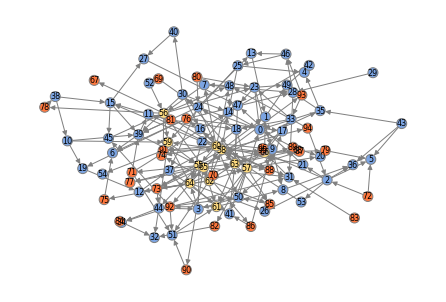

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

nx.write_gml(G, 'data/' + '/g_' +str(3) + '.gml')

# 选择布局
# pos = nx.random_layout(G) 
# pos = nx.shell_layout(G)
# pos = nx.planar_layout(G)
# pos = nx.spring_layout(G, seed=2)  # 弹簧布局
# pos = nx.circular_layout(G)  # 圆形布局
# pos = nx.spring_layout(G)  # 定义节点位置布局  # Kamada-Kawai 布局
pos = nx.kamada_kawai_layout(G)

# Define colors for each node type
node_colors = {
    'S': '#7ba4e2',   # Susceptible nodes
    'D': '#fdda80',    # Diseased nodes
    'I': '#ff783e'   # Infected nodes
}
        
# Extract node labels and colors
node_labels = {node: G.nodes[node]['type'] for node in G.nodes} 
node_colors = [node_colors[G.nodes[node]['type']] for node in G.nodes]

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', linewidths=1,font_size=8, font_color='black',node_size=100,edgecolors='gray')

# Customize plot layout
# plt.title('Graph Visualization with Node Types')
# 保存图形并指定 dpi 参数
plt.savefig('G', dpi=300)
plt.show()

# 生成数据并保存数据

In [4]:
import json
import networkx as nx
import os


for g_index in range(65,100):
    # 读取图
    G = nx.read_gml(f'data3/g_{g_index}.gml')
    print(1)

    #计算
    PMA_C=PMA_withoutrecon_ANC(G)
    print(2)
    RA_C=RA_withoutrecon_ANC(G)
    PSA_C=PSA_withoutrecon_ANC(G)
    PDA_C=PDA_withoutrecon_ANC(G)
    PIA_C=PIA_withoutrecon_ANC(G)
    print(3)

    PMA_RNC_C=PMA_random_ANC(G)
    RA_RNC_C=RA_random_ANC(G)
    PSA_RNC_C=PSA_random_ANC(G)
    PDA_RNC_C=PDA_random_ANC(G)
    PIA_RNC_C=PIA_random_ANC(G)

    PMA_MCNC_C=PMA_MaxSalton_ANC(G)
    RA_MCNC_C=RA_MaxSalton_ANC(G)
    PSA_MCNC_C=PSA_MaxSalton_ANC(G)
    PDA_MCNC_C=PDA_MaxSalton_ANC(G)
    PIA_MCNC_C=PIA_MaxSalton_ANC(G)

    PMA_MSNC_C=PMA_MaxFun_ANC(G)
    RA_MSNC_C=RA_MaxFun_ANC(G)
    PSA_MSNC_C=PSA_MaxFun_ANC(G)
    PDA_MSNC_C=PDA_MaxFun_ANC(G)
    PIA_MSNC_C=PIA_MaxFun_ANC(G)

    #######################
    PMA=PMA_withoutrecon_ANOC(G)
    PMA_MSNC=PMA_MaxSalton_ANOC(G)
    PMA_RNC=PMA_random_ANOC(G)
    PMA_MCNC=PMA_MaxFun_ANOC(G)

    RA=RA_withoutrecon_ANOC(G)
    RA_MSNC=RA_MaxSalton_ANOC(G)
    RA_RNC=RA_random_ANOC(G)
    RA_MCNC=RA_MaxFun_ANOC(G)

    PDA=PDA_withoutrecon_ANOC(G)
    PDA_MSNC=PDA_MaxSalton_ANOC(G)
    PDA_RNC=PDA_random_ANOC(G)
    PDA_MCNC=PDA_MaxFun_ANOC(G)

    PSA=PSA_withoutrecon_ANOC(G)
    PSA_MSNC=PSA_MaxSalton_ANOC(G)
    PSA_RNC= PSA_random_ANOC(G)
    PSA_MCNC=PSA_MaxFun_ANOC(G)

    PIA=PIA_withoutrecon_ANOC(G)
    PIA_MSNC=PIA_MaxSalton_ANOC(G)
    PIA_RNC=PIA_random_ANOC(G)
    PIA_MCNC=PIA_MaxFun_ANOC(G)


    #保存数据
    with open(f'data4/PMA_{g_index}.txt', 'w') as file:
        json.dump(PMA, file)
    with open(f'data4/PMA_MSNC_{g_index}.txt', 'w') as file:
        json.dump(PMA_MSNC, file)
    with open(f'data4/PMA_RNC_{g_index}.txt', 'w') as file:
        json.dump(PMA_RNC, file)
    with open(f'data4/PMA_MCNC_{g_index}.txt', 'w') as file:
        json.dump(PMA_MCNC, file)
    with open(f'data4/RA_{g_index}.txt', 'w') as file:
        json.dump(RA, file)
    with open(f'data4/RA_MSNC_{g_index}.txt', 'w') as file:
        json.dump(RA_MSNC, file)
    with open(f'data4/RA_RNC_{g_index}.txt', 'w') as file:
        json.dump(RA_RNC, file)
    with open(f'data4/RA_MCNC_{g_index}.txt', 'w') as file:
        json.dump(RA_MCNC, file)
    with open(f'data4/PDA_{g_index}.txt', 'w') as file:
        json.dump(PDA, file)
    with open(f'data4/PDA_MSNC_{g_index}.txt', 'w') as file:
        json.dump(PDA_MSNC, file)
    with open(f'data4/PDA_RNC_{g_index}.txt', 'w') as file:
        json.dump(PDA_RNC, file)
    with open(f'data4/PDA_MCNC_{g_index}.txt', 'w') as file:
        json.dump(PDA_MCNC, file)
    with open(f'data4/PSA_{g_index}.txt', 'w') as file:
        json.dump(PSA, file)
    with open(f'data4/PSA_MSNC_{g_index}.txt', 'w') as file:
        json.dump(PSA_MSNC, file)
    with open(f'data4/PSA_RNC_{g_index}.txt', 'w') as file:
        json.dump(PSA_RNC, file)
    with open(f'data4/PSA_MCNC_{g_index}.txt', 'w') as file:
        json.dump(PSA_MCNC, file)
    with open(f'data4/PIA_{g_index}.txt', 'w') as file:
        json.dump(PIA, file)
    with open(f'data4/PIA_MSNC_{g_index}.txt', 'w') as file:
        json.dump(PIA_MSNC, file)
    with open(f'data4/PIA_RNC_{g_index}.txt', 'w') as file:
        json.dump(PIA_RNC, file)
    with open(f'data4/PIA_MCNC_{g_index}.txt', 'w') as file:
        json.dump(PIA_MCNC, file)

    with open(f'data4/PMA_C_{g_index}.txt', 'w') as file:
        json.dump(PMA_C, file)
    with open(f'data4/PMA_MSNC_C_{g_index}.txt', 'w') as file:
        json.dump(PMA_MSNC_C, file)
    with open(f'data4/PMA_RNC_C_{g_index}.txt', 'w') as file:
        json.dump(PMA_RNC_C, file)
    with open(f'data4/PMA_MCNC_C_{g_index}.txt', 'w') as file:
        json.dump(PMA_MCNC_C, file)
    with open(f'data4/RA_C_{g_index}.txt', 'w') as file:
        json.dump(RA_C, file)
    with open(f'data4/RA_MSNC_C_{g_index}.txt', 'w') as file:
        json.dump(RA_MSNC_C, file)
    with open(f'data4/RA_RNC_C_{g_index}.txt', 'w') as file:
        json.dump(RA_RNC_C, file)
    with open(f'data4/RA_MCNC_C_{g_index}.txt', 'w') as file:
        json.dump(RA_MCNC_C, file)
    with open(f'data4/PDA_C_{g_index}.txt', 'w') as file:
        json.dump(PDA_C, file)
    with open(f'data4/PDA_MSNC_C_{g_index}.txt', 'w') as file:
        json.dump(PDA_MSNC_C, file)
    with open(f'data4/PDA_RNC_C_{g_index}.txt', 'w') as file:
        json.dump(PDA_RNC_C, file)
    with open(f'data4/PDA_MCNC_C_{g_index}.txt', 'w') as file:
        json.dump(PDA_MCNC_C, file)
    with open(f'data4/PSA_C_{g_index}.txt', 'w') as file:
        json.dump(PSA_C, file)
    with open(f'data4/PSA_MSNC_C_{g_index}.txt', 'w') as file:
        json.dump(PSA_MSNC_C, file)
    with open(f'data4/PSA_RNC_C_{g_index}.txt', 'w') as file:
        json.dump(PSA_RNC_C, file)
    with open(f'data4/PSA_MCNC_C_{g_index}.txt', 'w') as file:
        json.dump(PSA_MCNC_C, file)
    with open(f'data4/PIA_C_{g_index}.txt', 'w') as file:
        json.dump(PIA_C, file)
    with open(f'data4/PIA_MSNC_C_{g_index}.txt', 'w') as file:
        json.dump(PIA_MSNC_C, file)
    with open(f'data4/PIA_RNC_C_{g_index}.txt', 'w') as file:
        json.dump(PIA_RNC_C, file)
    with open(f'data4/PIA_MCNC_C_{g_index}.txt', 'w') as file:
        json.dump(PIA_MCNC_C, file)
    print(2)

1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2
1
2
3
2


In [2]:
# 初始化一个大字典来保存所有计算结果
import pandas as pd
results = {
    'PMA_ANOC': {},
    'PMA_RNC_ANOC': {},
    'PMA_MSSNC_ANOC': {},
    'PMA_MFSNC_ANOC': {},
    'RA_ANOC': {},
    'RA_RNC_ANOC': {},
    'RA_MSSNC_ANOC': {},
    'RA_MFSNC_ANOC': {},
    'PSA_ANOC': {},
    'PSA_RNC_ANOC': {},
    'PSA_MSSNC_ANOC': {},
    'PSA_MFSNC_ANOC': {},
    'PDA_ANOC': {},
    'PDA_RNC_ANOC': {},
    'PDA_MSSNC_ANOC': {},
    'PDA_MFSNC_ANOC': {},
    'PIA_ANOC': {},
    'PIA_RNC_ANOC': {},
    'PIA_MSSNC_ANOC': {},
    'PIA_MFSNC_ANOC': {},
    'PMA_ANC': {},
    'PMA_RNC_ANC': {},
    'PMA_MSSNC_ANC': {},
    'PMA_MFSNC_ANC': {},
    'RA_ANC': {},
    'RA_RNC_ANC': {},
    'RA_MSSNC_ANC': {},
    'RA_MFSNC_ANC': {},
    'PSA_ANC': {},
    'PSA_RNC_ANC': {},
    'PSA_MSSNC_ANC': {},
    'PSA_MFSNC_ANC': {},
    'PDA_ANC': {},
    'PDA_RNC_ANC': {},
    'PDA_MSSNC_ANC': {},
    'PDA_MFSNC_ANC': {},
    'PIA_ANC': {},
    'PIA_RNC_ANC': {},
    'PIA_MSSNC_ANC': {},
    'PIA_MFSNC_ANC': {}
}

number = 97

for g_index in range(100):    
    #读取数据with open('PMA.txt', 'r') as file:
    with open(f'data4/PMA_{g_index}.txt', 'r') as file:
        PMA = json.load(file)
    with open(f'data4/PMA_MSNC_{g_index}.txt', 'r') as file:
        PMA_MSNC = json.load(file)
    with open(f'data4/PMA_RNC_{g_index}.txt', 'r') as file:
        PMA_RNC = json.load(file) 
    with open(f'data4/PMA_MCNC_{g_index}.txt', 'r') as file:
        PMA_MCNC = json.load(file) 
    with open(f'data4/RA_{g_index}.txt', 'r') as file:
        RA = json.load(file)
    with open(f'data4/RA_MSNC_{g_index}.txt', 'r') as file:
        RA_MSNC = json.load(file)
    with open(f'data4/RA_RNC_{g_index}.txt', 'r') as file:
        RA_RNC = json.load(file) 
    with open(f'data4/RA_MCNC_{g_index}.txt', 'r') as file:
        RA_MCNC = json.load(file)
    with open(f'data4/PDA_{g_index}.txt', 'r') as file:
        PDA = json.load(file) 
    with open(f'data4/PDA_MSNC_{g_index}.txt', 'r') as file:
        PDA_MSNC = json.load(file)
    with open(f'data4/PDA_RNC_{g_index}.txt', 'r') as file:
        PDA_RNC = json.load(file)
    with open(f'data4/PDA_MCNC_{g_index}.txt', 'r') as file:
        PDA_MCNC = json.load(file)
    with open(f'data4/PSA_{g_index}.txt', 'r') as file:
        PSA = json.load(file)
    with open(f'data4/PSA_MSNC_{g_index}.txt', 'r') as file:
        PSA_MSNC = json.load(file)
    with open(f'data4/PSA_RNC_{g_index}.txt', 'r') as file:
        PSA_RNC = json.load(file)
    with open(f'data4/PSA_MCNC_{g_index}.txt', 'r') as file:
        PSA_MCNC = json.load(file)
    with open(f'data4/PIA_{g_index}.txt', 'r') as file:
        PIA = json.load(file)
    with open(f'data4/PIA_MSNC_{g_index}.txt', 'r') as file:
        PIA_MSNC = json.load(file)
    with open(f'data4/PIA_MSNC_{g_index}.txt', 'r') as file:
        PIA_MSNC = json.load(file)
    with open(f'data4/PIA_RNC_{g_index}.txt', 'r') as file:
        PIA_RNC = json.load(file)
    with open(f'data4/PIA_MCNC_{g_index}.txt', 'r') as file:
        PIA_MCNC = json.load(file)

       
        
    with open(f'data4/PMA_C_{g_index}.txt', 'r') as file:
        PMA_C = json.load(file)
    with open(f'data4/PMA_MSNC_C_{g_index}.txt', 'r') as file:
        PMA_MSNC_C = json.load(file)
    with open(f'data4/PMA_RNC_C_{g_index}.txt', 'r') as file:
        PMA_RNC_C = json.load(file) 
    with open(f'data4/PMA_MCNC_C_{g_index}.txt', 'r') as file:
        PMA_MCNC_C = json.load(file) 
    with open(f'data4/RA_C_{g_index}.txt', 'r') as file:
        RA_C = json.load(file)
    with open(f'data4/RA_MSNC_C_{g_index}.txt', 'r') as file:
        RA_MSNC_C = json.load(file)
    with open(f'data4/RA_RNC_C_{g_index}.txt', 'r') as file:
        RA_RNC_C = json.load(file) 
    with open(f'data4/RA_MCNC_C_{g_index}.txt', 'r') as file:
        RA_MCNC_C = json.load(file)
    with open(f'data4/PDA_C_{g_index}.txt', 'r') as file:
        PDA_C = json.load(file) 
    with open(f'data4/PDA_MSNC_C_{g_index}.txt', 'r') as file:
        PDA_MSNC_C = json.load(file)
    with open(f'data4/PDA_RNC_C_{g_index}.txt', 'r') as file:
        PDA_RNC_C = json.load(file)
    with open(f'data4/PDA_MCNC_C_{g_index}.txt', 'r') as file:
        PDA_MCNC_C = json.load(file)
    with open(f'data4/PSA_C_{g_index}.txt', 'r') as file:
        PSA_C = json.load(file)
    with open(f'data4/PSA_MSNC_C_{g_index}.txt', 'r') as file:
        PSA_MSNC_C = json.load(file)
    with open(f'data4/PSA_RNC_C_{g_index}.txt', 'r') as file:
        PSA_RNC_C = json.load(file)
    with open(f'data4/PSA_MCNC_C_{g_index}.txt', 'r') as file:
        PSA_MCNC_C = json.load(file)
    with open(f'data4/PIA_C_{g_index}.txt', 'r') as file:
        PIA_C = json.load(file)
    with open(f'data4/PIA_MSNC_C_{g_index}.txt', 'r') as file:
        PIA_MSNC_C = json.load(file)
    with open(f'data4/PIA_RNC_C_{g_index}.txt', 'r') as file:
        PIA_RNC_C = json.load(file)
    with open(f'data4/PIA_MCNC_C_{g_index}.txt', 'r') as file:
        PIA_MCNC_C = json.load(file)

    # 将所有结果存储到对应的字典键下
   
    results['PMA_ANOC'][g_index] = np.sum(PMA[1:], axis=0) / number
    results['PMA_RNC_ANOC'][g_index] = np.sum(PMA_RNC[1:], axis=0) / number
    results['PMA_MSSNC_ANOC'][g_index] = np.sum(PMA_MSNC[1:], axis=0) / number
    results['PMA_MFSNC_ANOC'][g_index] = np.sum(PMA_MCNC[1:], axis=0) / number

    results['RA_ANOC'][g_index] = np.sum(RA[1:], axis=0) / number
    results['RA_RNC_ANOC'][g_index] = np.sum(RA_RNC[1:], axis=0) / number
    results['RA_MSSNC_ANOC'][g_index] = np.sum(RA_MSNC[1:], axis=0) / number
    results['RA_MFSNC_ANOC'][g_index] = np.sum(RA_MCNC[1:], axis=0) / number

    results['PSA_ANOC'][g_index] = np.sum(PSA[1:], axis=0) / number
    results['PSA_RNC_ANOC'][g_index] = np.sum(PSA_RNC[1:], axis=0) / number
    results['PSA_MSSNC_ANOC'][g_index] = np.sum(PSA_MSNC[1:], axis=0) / number
    results['PSA_MFSNC_ANOC'][g_index] = np.sum(PSA_MCNC[1:], axis=0) / number

    results['PDA_ANOC'][g_index] = np.sum(PDA[1:], axis=0) / number
    results['PDA_RNC_ANOC'][g_index] = np.sum(PDA_RNC[1:], axis=0) / number
    results['PDA_MSSNC_ANOC'][g_index] = np.sum(PDA_MSNC[1:], axis=0) / number
    results['PDA_MFSNC_ANOC'][g_index] = np.sum(PDA_MCNC[1:], axis=0) / number

    results['PIA_ANOC'][g_index] = np.sum(PIA[1:], axis=0) / number
    results['PIA_RNC_ANOC'][g_index] = np.sum(PIA_RNC[1:], axis=0) / number
    results['PIA_MSSNC_ANOC'][g_index] = np.sum(PIA_MSNC[1:], axis=0) / number
    results['PIA_MFSNC_ANOC'][g_index] = np.sum(PIA_MCNC[1:], axis=0) / number

    results['PMA_ANC'][g_index] = np.sum(PMA_C[1:], axis=0) / number
    results['PMA_RNC_ANC'][g_index] = np.sum(PMA_RNC_C[1:], axis=0) / number
    results['PMA_MSSNC_ANC'][g_index] = np.sum(PMA_MSNC_C[1:], axis=0) / number
    results['PMA_MFSNC_ANC'][g_index] = np.sum(PMA_MCNC_C[1:], axis=0) / number

    results['RA_ANC'][g_index] = np.sum(RA_C[1:], axis=0) / number
    results['RA_RNC_ANC'][g_index] = np.sum(RA_RNC_C[1:], axis=0) / number
    results['RA_MSSNC_ANC'][g_index] = np.sum(RA_MSNC_C[1:], axis=0) / number
    results['RA_MFSNC_ANC'][g_index] = np.sum(RA_MCNC_C[1:], axis=0) / number

    results['PSA_ANC'][g_index] = np.sum(PSA_C[1:], axis=0) / number
    results['PSA_RNC_ANC'][g_index] = np.sum(PSA_RNC_C[1:], axis=0) / number
    results['PSA_MSSNC_ANC'][g_index] = np.sum(PSA_MSNC_C[1:], axis=0) / number
    results['PSA_MFSNC_ANC'][g_index] = np.sum(PSA_MCNC_C[1:], axis=0) / number

    results['PDA_ANC'][g_index] = np.sum(PDA_C[1:], axis=0) / number
    results['PDA_RNC_ANC'][g_index] = np.sum(PDA_RNC_C[1:], axis=0) / number
    results['PDA_MSSNC_ANC'][g_index] = np.sum(PDA_MSNC_C[1:], axis=0) / number
    results['PDA_MFSNC_ANC'][g_index] = np.sum(PDA_MCNC_C[1:], axis=0) / number

    results['PIA_ANC'][g_index] = np.sum(PIA_C[1:], axis=0) / number
    results['PIA_RNC_ANC'][g_index] = np.sum(PIA_RNC_C[1:], axis=0) / number
    results['PIA_MSSNC_ANC'][g_index] = np.sum(PIA_MSNC_C[1:], axis=0) / number
    results['PIA_MFSNC_ANC'][g_index] = np.sum(PIA_MCNC_C[1:], axis=0) / number
    
# 使用ExcelWriter保存DataFrame到Excel
with pd.ExcelWriter('results2.xlsx') as writer:
    for key, value in results.items():
        # 将每个空字典转换为DataFrame
        df = pd.DataFrame([value])
        # 写入Excel的单独工作表，表名为字典的键
        df.to_excel(writer, sheet_name=key, index=False)

print("字典已成功导出至Excel文件：results2.xlsx")


字典已成功导出至Excel文件：results2.xlsx
